In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

import numpy as np
import pandas as pd
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix

from sklearn.linear_model import LinearRegression
from sklearn.svm import SVC

#### Imports for Cross-Validation

In [3]:
from sklearn.model_selection import cross_val_score #k-Fold Cross Validation
from sklearn.model_selection import GridSearchCV

    
## Model Validation Methods

We have been splitting the data into training sets and test sets. This is called the Holdout method. We need to modify this approach to improve model performance and to tune hyperparameters. The changes are:

* Adding a validation set to our training and test sets to tune hyperparmeters
* Use Cross-Validation methods.


 

###  Potential Drawbacks of Holdout Approach

It is highly variable since it depends on which observations are included in the test set.  
    
It overestimates test error rate for entire data set since model is trained on fewer observations which increased bias.

#### Variability using single sample

In [4]:
df = pd.read_csv("Auto.csv")
df.tail()

,mpg,cylinders,displacement,horsepower,weight,acceleration,year,origin
387,27.0,4,140.0,86,2790,15.6,82,1
388,44.0,4,97.0,52,2130,24.6,82,2
389,32.0,4,135.0,84,2295,11.6,82,1
390,28.0,4,120.0,79,2625,18.6,82,1
391,31.0,4,119.0,82,2720,19.4,82,1


#### Create degree 5 polynomial array of horsepower

In [5]:
x = df.loc[:,"horsepower"].values
X = np.array([x**(n+1) for n in range(5)]).transpose()
y = df.loc[:,"mpg"].values
X[0,:]

array([        130,       16900,     2197000,   285610000, 37129300000],
      dtype=int64)

#### Function to obtain a sample split,then fit and predict different degree polynomials. Returns MSE.

In [6]:
def one_epoch(X,y,degree):
    X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size = 0.20)
    models = [LinearRegression() for i in range(degree)]
    mses = np.zeros(degree)
    for i in range(degree):
        models[i].fit(X_train[:,0:(i+1)], y_train)
        preds = models[i].predict(X_test[:,0:(i+1)])
        mses[i] = np.mean((y_test - preds)**2)
    return mses

#### Run 4 epochs

In [7]:
num_epochs = 4
num_degrees = 5
mses = [one_epoch(X,y,num_degrees) for i in range(num_epochs)]
print(f'Degree with lowest MSE {list(map(np.argmin,mses))}')
msesT = np.array(mses).T

Degree with lowest MSE [4, 2, 2, 4]


#### Plot epochs (i.e. different samples) for each degree polynomial

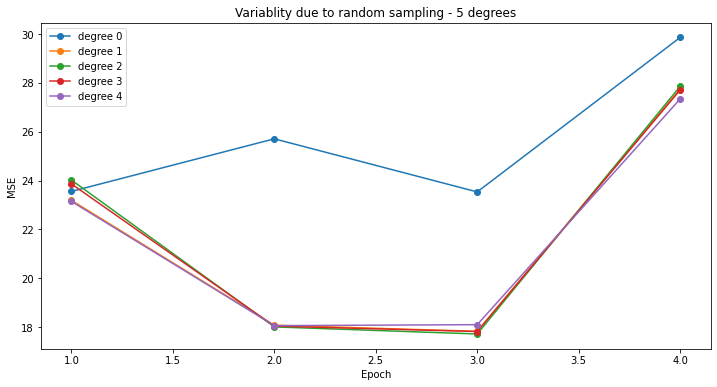

In [8]:
fig,ax = plt.subplots(figsize = (12,6))
x = (1,2,3,4)
legend = []
for i in range(5):
    ax.plot(x,msesT[i],'o-')
    legend.append(f'degree {i}')
plt.xlabel("Epoch")
plt.ylabel("MSE")
plt.legend((legend))
plt.title(f"Variablity due to random sampling - {5} degrees");

#### Plot polynomial degree for each epoch

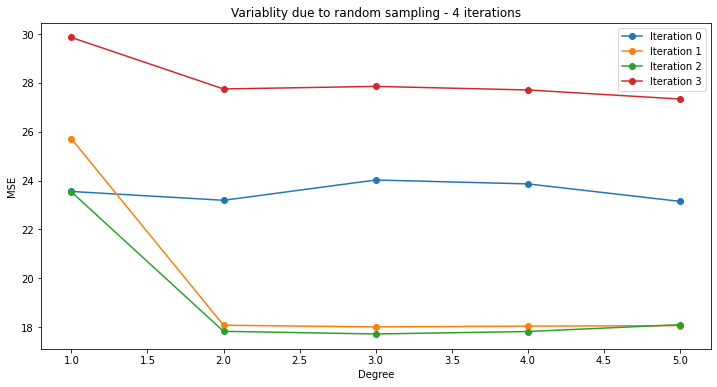

In [9]:
fig,ax = plt.subplots(figsize = (12,6))
x = range(1,6)
legend = []
for i in range(num_epochs):
    ax.plot(x,mses[i],'o-')
    legend.append(f'Iteration {i}')
plt.xlabel("Degree")
plt.ylabel("MSE")
plt.legend((legend))
plt.title(f"Variablity due to random sampling - {num_epochs} iterations");


### Hyperparameter Tuning using Validation Set

When the model has hyperparameters we need to use a validation set to tune the hyperparameters.

We split the the data into three sets by: 

* Splitting the data into two sets. The second set will be the test set
* Then split the first set into two sets into a training set and a validation set.

Train the model using the training set and then tune the hyperparameters using the validation set. Retrain the model on the original training set.


In [10]:
penguins = sns.load_dataset('penguins')
penguins.dropna(inplace=True)
penguins.tail()

,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex
338,Gentoo,Biscoe,47.2,13.7,214.0,4925.0,Female
340,Gentoo,Biscoe,46.8,14.3,215.0,4850.0,Female
341,Gentoo,Biscoe,50.4,15.7,222.0,5750.0,Male
342,Gentoo,Biscoe,45.2,14.8,212.0,5200.0,Female
343,Gentoo,Biscoe,49.9,16.1,213.0,5400.0,Male


In [11]:
X = penguins.iloc[:, 2:6].values
y = penguins.loc[:, 'species'].values
X.shape,y.shape

((333, 4), (333,))

In [12]:
X_train,X_test,y_train,y_test = train_test_split(X, y, 
                                                 test_size = 0.20,
                                                 stratify=y,
                                                 random_state=4)

X_train2,X_val,y_train2,y_val = train_test_split(X_train,y_train,
                                                 test_size = .20,
                                                 stratify=y_train,
                                                 random_state=4)
#Scale featues
sc = StandardScaler()
X_train2 = sc.fit_transform(X_train2)
X_val = sc.transform(X_val)
X_train2.shape,X_val.shape,y_train2.shape,y_val.shape

((212, 4), (54, 4), (212,), (54,))

In [13]:
parameters = (.1,1.0,10.0,100.0)
scores = np.zeros(len(parameters))
for i,param in enumerate(parameters):
    svc_model = SVC(C = param, kernel = 'linear', random_state = 1234)
    svc_model.fit(X_train2, y_train2)
    scores[i] = svc_model.score(X_val,y_val)
print(scores)
best_C = parameters[np.argmax(scores)]
print(f'Best parameter is {best_C}')

[1.         1.         0.98148148 1.        ]
Best parameter is 0.1


#### Refit  and test model with best hyperparameter

In [14]:
#Scale featues
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)
X_train.shape,X_test.shape,y_train.shape,y_test.shape

final_model = SVC(C = best_C, kernel = 'linear', random_state = 1234)
final_model.fit(X_train, y_train)
final_model.score(X_test,y_test)

0.9850746268656716

## Cross-Validation

Cross-Validation is a resampling method. Given a training set, repeatedly draw samples from that set and refit the model on each sample to gain additional information about the fitted model. By resampling cross-validation makes optimal use of the data collected. Cross-Validation can be computationally expensive but with today's computing power resampling methods are tractable. 


Cross-Validation is used for:

* Model assessment on the test data  
* Model selection of appropriate level of complexity (flexibility).

#### Model Assessment ( Accuracy/Test Error Rate)
 
Accuracy of the test set will vary depending on the particular sample. More complex models will vary more from sample to sample. Cross-Validation will improve accuracy by reducing bias.
    


### k-fold Cross-Validation 

#### Algorithm

1. Obtain a dataset
    - Shuffle the dataset (optional) 
2. Randomly divide the data into k groups or folds of approximately equal size  
3. For each of the k folds  
    a. Make it the validation set  
    b. Fit learning method on k-1 remaining folds  
    c. Predict the validation set  
    d. Calculate Cross Validation score on the MSE of validation set  
4. Average the Cross Validation scores for a final performance measure 

<div style="font-size: 115%;">
$$CV_{(k)} = \frac{1}{k}\sum^k_{i}MSE_i$$
</div>

![](k-fold.png)
$$\text{Figure 1. 5-fold Cross Validation}$$  

Each observation in the original sample is used once in the validation set and k-1 times in the training set.

This method has a lower bias than a simple train/test split. It is less prone to underestimate the test error.

Any scaling or tuning of hyperparameters must be done within step three to prevent data leakage.

k = 5 or k = 10 have been found to produce the best results (i.e. best bias-variance tradeoff):

- k = 1 is the simple train/test split that we have been doing  
- k = n is called Leave-One-Out Cross Validation (see below)

Stratified Cross Validation is used in Classification. Each fold has the same proportion of observations with a given categorical value.

Repeated Cross Validation repeats the Cross Validation procedure N times

 

#### k-fold Cross Validation in Classification

Use number of misclassifications to quantify test error

<div style="font-size: 115%;">
$$CV_{(k)} = \frac{1}{k}\sum^k_{i}I(y_i\ne{\hat{y}_i})$$
</div>

#### Leave-One-Out Cross (LOOC) Validation
 
Given $(x_1,y_1)$,$(x_2,y_2)$,...,$(x_n,y_n)$  

Let: $(x_1,y_1)$ be the validation set and $(x_2,y_2)$,...,$(x_n,y_n)$ be the training set.

Fit the model on the training set and calculate $MSE_1$
Predict $\hat{y_1}$ based on $x_1$  
Calculate $MSE_1 = mean(y_1 - \hat{y_1})^2)$  
Repeat for 2,...,n  
    
<div style="font-size: 115%;">
$$CV_{(n)} = \frac{1}{n}\sum^n_{i}MSE_i$$
</div>

Leave-One-Out Cross Validation has less bias since uses almost all the data in the training set.

There is no randomness in training/test set splits, but can be computationally expensive and has high variance because:
- Averaging the ouputs of n fitted models trained on datasets that are highly correlated. 
- Variance of correlated variables higher than for non-correlated variables

$$Var(X + Y) = Var(X) + Var(Y) + 2\cdot{Cov(X,Y)}$$

### Sklearn Cross-Validation

http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_val_score.html

In [15]:
Purchase = pd.read_csv('PurchaseData.csv')
Purchase.tail()

,Gender,Age,Salary,Purchased
395,Female,46,41000,1
396,Male,51,23000,1
397,Female,50,20000,1
398,Male,36,33000,0
399,Female,49,36000,1


In [16]:
X = Purchase.iloc[:, [1, 2]].values
y = Purchase.iloc[:, 3].values
X.shape,y.shape

((400, 2), (400,))

In [17]:
# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size = 0.25,
                                                    random_state = 12,
                                                    stratify = y)

#Scale featues
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)
X_train.shape, X_test.shape, y_train.shape, y_test.shape 

((300, 2), (100, 2), (300,), (100,))

In [18]:
# Fitting Kernel SVM to the Training set

svc_model = SVC(kernel = 'rbf', random_state = 1234)
svc_model.fit(X_train, y_train)

# Predict test data
y_pred = svc_model.predict(X_test)

# Make the Confusion Matrix

cm = confusion_matrix(y_test, y_pred)
print(cm)
accuracy = np.trace(cm)/np.sum(cm)
accuracy

[[57  7]
 [ 3 33]]


0.9

In [19]:
svc_model.score(X_train,y_train)

0.9166666666666666

In [20]:
# Applying k-Fold Cross Validation

n_folds = 10

# score function from SVC
scores = cross_val_score(estimator = SVC(), X = X_train, y = y_train, cv = n_folds)
scores

array([1.        , 0.83333333, 0.96666667, 0.9       , 0.9       ,
       0.9       , 0.93333333, 0.96666667, 0.9       , 0.86666667])

Mean accuracy:  0.9166666666666667
Stanard Deviation of accuracies:  0.04772607021092117
95% Confidence Interval: 0.917 +/- 0.095


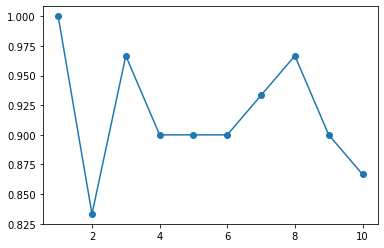

In [21]:
plt.plot(range(1,11),scores,"o-")
print("Mean accuracy: ",scores.mean())
print("Stanard Deviation of accuracies: ",scores.std())
print(f'95% Confidence Interval: {round(scores.mean(),3)} +/- {round(2*scores.std(),3)}')


In [22]:
np.mean(scores)

0.9166666666666667

### Grid search cross validation

There are two types of parameters:

- Parameters that are learned by model  
- Parameters that are set by the modeler, called hyperparameters

![](CrossVal.png)

$\text{Figure 2. Cross-Validation Workflow}$

#### sklearn Grid Search

http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html


Grid search is a method to find for the optimal hyperparameters. Where optimal means the ones with the best Cross Validation scores.

Parameters:
- param_grid: dictionary of hyperparamters and values to search over
- estimator: the model object
- cv: the number of cv folds
- scoring: "accuracy" for classification, "r2" for regression
        - calls accuracy_score or r2_score
        
Result attributes:
- best_score_
- best_params_  
- cv_results_

In [23]:
# Grid Search Python
# Applying Grid Search to find the best model and the best parameters

parameters = [{'C': [1, 10, 100, 1000], 'kernel': ['linear']},
              {'C': [1, 10, 100, 1000], 'kernel': ['rbf'], 
               'gamma': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]}]
grid_search = GridSearchCV(estimator = SVC(),
                           param_grid = parameters,
                           scoring = 'accuracy',
                           cv = 10,
                           n_jobs = -1)
grid_search = grid_search.fit(X_train, y_train)
best_accuracy = grid_search.best_score_
best_parameters = grid_search.best_params_
print("Best accuracy: ", best_accuracy)
print("Best parameters: ", best_parameters )

Best accuracy:  0.9200000000000002
Best parameters:  {'C': 10, 'gamma': 0.3, 'kernel': 'rbf'}


In [24]:
svc_model = SVC(C = 10, kernel = 'rbf', gamma = 0.3)
svc_model.fit(X_train, y_train)

# Predict test data
y_pred = svc_model.predict(X_test)

# Make the Confusion Matrix

cm = confusion_matrix(y_test, y_pred)
print(cm)
accuracy = np.trace(cm)/np.sum(cm)
accuracy

[[57  7]
 [ 3 33]]


0.9

In [25]:
grid_search.cv_results_

{'mean_fit_time': array([0.00479977, 0.00720005, 0.01899922, 0.11609902, 0.00450001,
        0.00379927, 0.00360117, 0.00399802, 0.0029002 , 0.00319984,
        0.00329981, 0.00340011, 0.00359957, 0.00560052, 0.00400014,
        0.00559905, 0.00410061, 0.00500002, 0.00469954, 0.00369883,
        0.00319908, 0.00339992, 0.00399942, 0.00339911, 0.00399921,
        0.00489926, 0.00489979, 0.00639911, 0.00579963, 0.00600059,
        0.00629966, 0.00869918, 0.01679986, 0.01310036, 0.01479857,
        0.01819928, 0.01556418, 0.01540036, 0.0153656 , 0.01249971]),
 'std_fit_time': array([0.00040099, 0.00146977, 0.00402489, 0.02477329, 0.00156475,
        0.00039957, 0.00066409, 0.00063281, 0.00053798, 0.0003997 ,
        0.00045835, 0.0008003 , 0.00048958, 0.00506305, 0.00099833,
        0.00484217, 0.00169907, 0.00438192, 0.00316343, 0.00045763,
        0.00060055, 0.0004906 , 0.00077463, 0.00102054, 0.00141442,
        0.00094481, 0.0009429 , 0.00149713, 0.00146961, 0.00148334,
        0.001

#### Figures



Figures 1: "An Introduction to Statistical Learning, with applications in R" (Springer, 2013) with permission from the authors: G. James, D. Witten, T. Hastie and R. Tibshirani 

Figure 2: Sklearn Cross-Validation Users Guide